# Use case Schouwen Westkop Noord

## 1. Import functionality

In [1]:
from functions import *
coords_WGS = np.loadtxt('E:/Use_case_Schouwen/baty_WGS.csv')   
import halem.Base_functions as halem

## 3. User defined values

In [2]:
load_factor =np.array([0])                           # Roadmap11
 
start = [3.674, 51.70969009]                          # Location of the koppelpunt                             (lon, lat)
stop = [3.522637481591586,51.76880095558772]          # Location of the dredging area                          (lon, lat)
Volume = 425_500                                       # Total volume to be dregded                             (m^3)

unloading_rate = 1.5
loading_rate = 1.5
ukc = 1.0                                             # Under Keel clearance                                   (m)
WWL = 20                                              # Width on Water Line                                    (m)
LWL = 80                                              # Length on Water Line                                   (m)
hopper_capacity = 4000                                # Maximal capacity of the hopper                         (m^3)
V_full = 10*0.514444444                               # Velocity in deep water when maximal loaded             (m/s)
V_emp = 12*0.514444444                                # Maximal sailing velocity empty in deep water           (m/s)
T_full = 6.5                                          # Draft when maximal Loaded                              (m)
T_emp = 3.5                                           # Draft When empty                                       (m)
WVPI_full = 10000                                     # Weight when maximal loaded                             (tf)
WVPI_empt = 4000                                      # Weight empty                                           (tf)

Q_velo = compute_v_provider(V_emp, V_full)            # Vessel velocity is dependent on load factor


service_hours = 168                                   # hours per week
delay_for_bunkering = 10                              # hours per week
technical_delay = 10                                  # hours per week
project_related_delay = 3                             # hours per week

load_factor

array([0])

## 4. Road map generation

In [3]:
nl = (0.5,1.5)
dx_min = 0.02
blend = 0.8
number_of_neighbor_layers = 3

vship =np.transpose([interpolate(load_factor, V_full, V_emp)])

WD_min= interpolate(load_factor, T_full, T_emp)
WVPI  = interpolate(load_factor, WVPI_full, WVPI_empt)

Load_flow = flow_class.flow_tides
name_textfile_flow = 'E:/Use_case_Schouwen/flow_Noos_real'

In [4]:
start_time = time.time()

Roadmap   = Mesh_maker.Graph_flow_model(name_textfile_flow, 
                                        dx_min, 
                                        blend, 
                                        nl, 
                                        number_of_neighbor_layers, 
                                        vship, 
                                        Load_flow, 
                                        WD_min,
                                        WVPI,
                                        WWL = WWL,
                                        ukc = ukc,
                                        repeat = False,
                                        nodes_index = np.arange(2911),
                                        optimization_type=['time']
                                       )

stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

halem.save_object(Roadmap, 'Roadmap11SIM')

4/4
the computational time is: 806.33 sec


In [5]:
# name_textfile_load = 'Roadmap11SIM'

# with open(name_textfile_load, 'rb') as input:
#     Roadmap = pickle.load(input)

## 5. calculate optimal routes

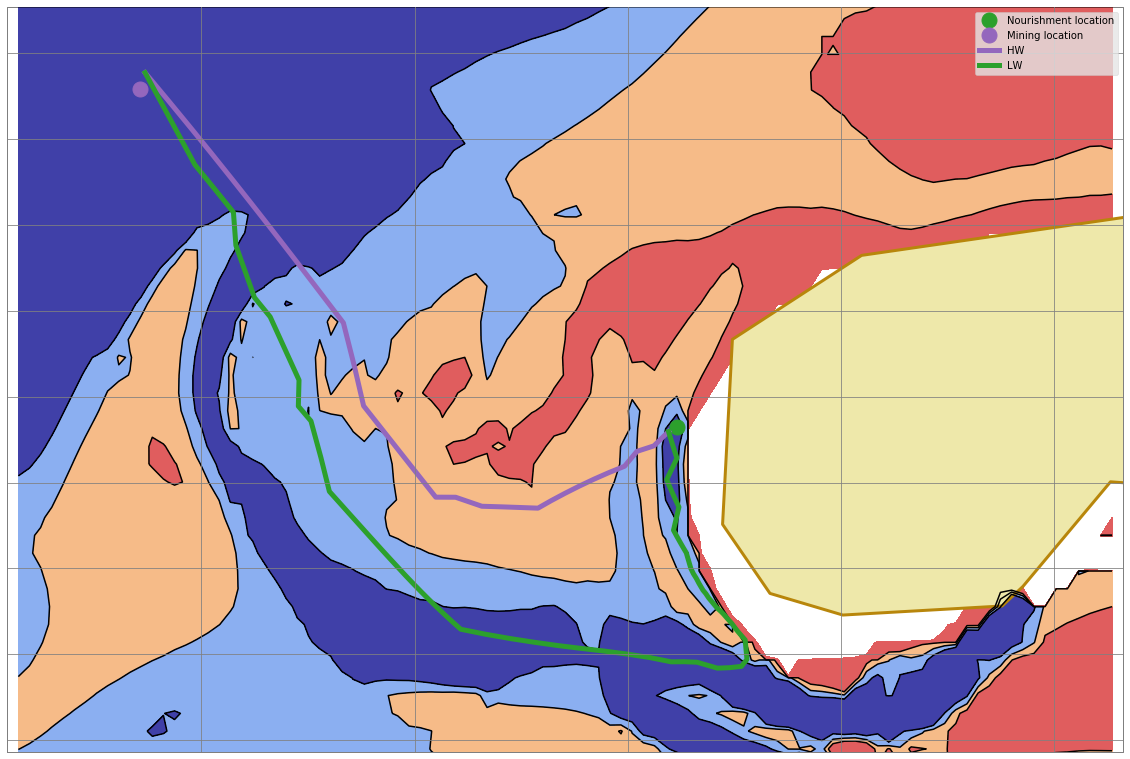

In [25]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Plot Background
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

D_emp = 4.0
D_full = 8.0
ukc = 1.0
tide = -1.3

N = 100
x_r = np.arange(coords_WGS[:,0].min(), coords_WGS[:,0].max(), (coords_WGS[:,0].max() - coords_WGS[:,0].min())/N)
y_r = np.arange(coords_WGS[:,1].min(), coords_WGS[:,1].max(), (coords_WGS[:,1].max() - coords_WGS[:,1].min())/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')
cval = [-1000,D_emp + ukc -3.3, D_emp +ukc, D_full+ukc, 100]
cval2 = [D_emp + ukc - 3.3, D_emp +ukc, D_full+ukc]

fig = plt.figure(figsize = (20,20))

ax = plt.subplot(projection=ccrs.Mercator())
im = plt.contourf(x_r,y_r,WD_r,cval,
                  transform=ccrs.PlateCarree(), 
                  colors = ('tab:red','sandybrown', 'cornflowerblue', 'darkblue'),
                  alpha = 0.75
                 )
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.coastlines(resolution='10m', color='darkgoldenrod', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.set_extent([coords_WGS[:,0].min(),coords_WGS[:,0].max(),coords_WGS[:,1].min()*1.0015,coords_WGS[:,1].max()*0.998])
plt.plot(start[0], 
         start[1],
         'o',
         color = 'tab:green',
         transform=ccrs.PlateCarree(), 
         label =  'Nourishment location', 
         markersize = 15
        )

plt.plot(stop[0], 
         stop[1], 
         'o',color = 'tab:purple',
         transform=ccrs.PlateCarree() , 
         label = 'Mining location', 
         markersize = 15
        )

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Calclate different routes 
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# Calculation at HHW and at LLW for a empty shipt from nourishment to dredging area

ind = halem.Calc_path.Has_route.find_startstop(None, start[::-1], Roadmap.nodes)
ind = np.argwhere(Roadmap.WD[ind,:] == Roadmap.WD[ind,75:125].max())[0][0]
t0 = datetime.datetime.fromtimestamp(Roadmap.t[ind]+12).strftime('%d/%m/%Y %H:%M:%S')

Path, timePath, dist = halem.HALEM_time(start,
                                        stop,
                                        t0 ,
                                        vship[0][0],
                                        Roadmap
                                       )


ind = halem.Calc_path.Has_route.find_startstop(None, start[::-1], Roadmap.nodes)
ind = np.argwhere(Roadmap.WD[ind,:] == Roadmap.WD[ind,:].min())[0][0]
t1 = datetime.datetime.fromtimestamp(Roadmap.t[ind]).strftime('%d/%m/%Y %H:%M:%S')

Path2, timePath2, dist2 = halem.HALEM_time(start, 
                                           stop,
                                           t1 ,
                                           vship[0][0],
                                           Roadmap
                                          )

plt.plot(Path[:,0], 
         Path[:,1], 
         label = 'HW',
         transform=ccrs.PlateCarree(), 
         color = 'tab:purple',
         linewidth = 5
        )

plt.plot(Path2[:,0],
         Path2[:,1],
         label = 'LW',
         transform=ccrs.PlateCarree(),
         color = 'tab:green',
         linewidth = 5
        )

ax.legend()
plt.show()

290

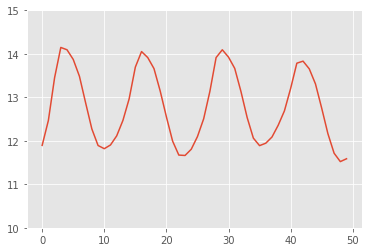

In [24]:
ind = halem.Calc_path.Has_route.find_startstop(None, start[::-1], Roadmap.nodes)
plt.plot(Roadmap.WD[ind,75:125])
plt.ylim(10,15)
np.argwhere(Roadmap.WD[ind,:] == Roadmap.WD[ind,:500].max())[0][0]